<a href="https://colab.research.google.com/github/mayraberrones94/Analisis_Algoritmos/blob/master/PIA3_EjercicioMan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

import math

In [12]:
# Genero los datos
def make_circle(r, n, noise = 30, seed = 1234):
  np.random.seed(seed)
  return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-noise,noise), math.sin(2*math.pi/n*x)*r+np.random.normal(-noise,noise)) for x in range(1,n+1)]

small_circle = make_circle(100, 300, 10)
medium_circle = make_circle(300, 700, 20)
big_circle = make_circle(500, 1000, 30)

noise = [(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)]

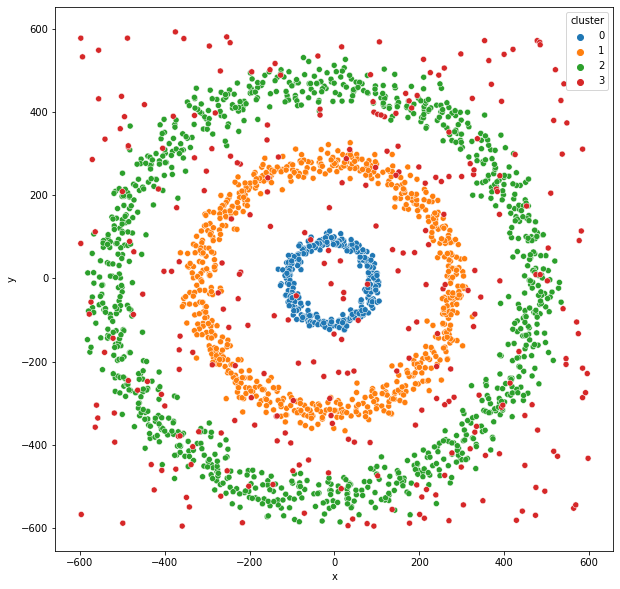

In [13]:
# Convertimos a DF
def arrray_to_df(arr, i):
  df = pd.DataFrame(arr)
  df['cluster'] = str(i)
  return df

data = [arrray_to_df(arr, i) for i, arr in enumerate([small_circle, medium_circle, big_circle, noise])]

data = pd.concat(data)
data.columns = ['x', 'y', 'cluster']


plt.rcParams['figure.figsize'] = [10,10]
sns.scatterplot(
    data = data, 
    x = 'x',
    y = 'y',
    hue = 'cluster'
)

In [14]:
class dbscan:

  def __init__(self, epsilon = None, min_samples = None, distance = 'euclidean', normalize = False):
    self.epsilon = epsilon
    self.min_samples = min_samples
    self.distance = distance
    self.normalize = normalize

  def find_distance(self, x, type = 'euclidean'):
    """
    Finds distance between numpy arrays.
    """
    return distance.squareform(distance.pdist(x, type))

  def normalization(self, x):
    return (x-np.min(x))/(np.max(x) - np.min(x))

  def find_neighbors(self, x):
    return np.where(x <= self.epsilon)[0]
  
  def expand_cluster(self, neighbors, x, cluster, labels):

    # Iterate over each neighbor
    for neighbor in neighbors:
      
      # Check that is not assigned
      if labels[neighbor] == 0:

        # Find neighbors
        neighbor_neighbors = self.find_neighbors(x[neighbor])
        
        # Check if is core
        if len(neighbor_neighbors) >= self.min_samples:
            labels[neighbor] = cluster

            # For each neighbor in neighbors, expand cluster
            labels = self.expand_cluster(neighbor_neighbors, x, cluster, labels)
      
    return labels

  def fit(self, x):
    """
    Given a reference point and comparison points and a distance function, returns the index of the neighbors.
    """
    # Do normalization
    if self.normalize:
      x = self.normalization(x)

    # Find distance
    dist_matrix = self.find_distance(x, self.distance)

    # Initialize cluster
    cluster = 1
    n_obs = x.shape[0]
    labels = np.zeros(n_obs)

    for i in range(n_obs):
    
      # If value not assigned
      if labels[i] == 0:
        
        # Find neighbors
        neighbors = self.find_neighbors(dist_matrix[i])

        # Check if neighbors > min_samples (self included as neighbor)
        if len(neighbors) > self.min_samples:
        
          # If observation is not assigned --> Assign to cluster
          if labels[i] == 0:
            labels[i] = cluster

          # Expand cluster on neighbors
          labels = self.expand_cluster(neighbors, dist_matrix, cluster, labels)

          # Go to next cluster          
          cluster = cluster + 1

    return labels

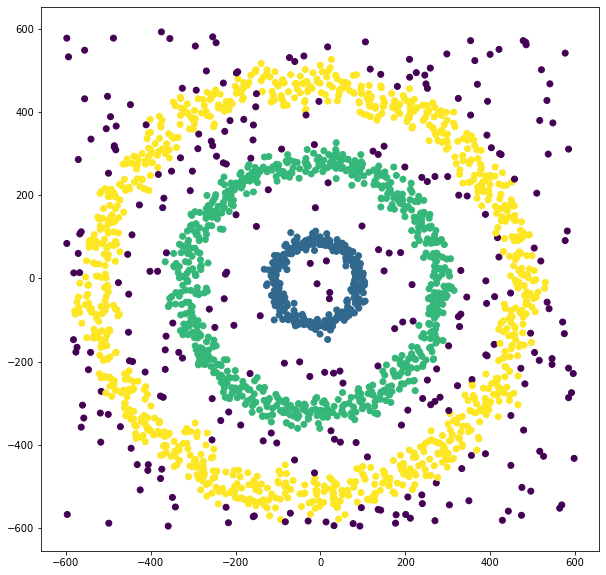

In [15]:
data['dbscan_custom'] = dbscan(epsilon=32, min_samples=5).fit(data[['x', 'y']].to_numpy())

plt.scatter(
    data['x'],
    data['y'],
    c = data['dbscan_custom']
)